In [1]:
%run "DataPreparation.ipynb";
%run "Modeling.ipynb";

In [2]:
# Setup
images_dir= "../Images" #images
json_dir = "../Data" #json

# Loading JSON data into dataframe for building localization
hurricane_pre_df, hurricane_post_df, pre_hurricane_images, post_hurricane_images = prepare_data(images_dir, json_dir);

Retrieving pre and post disaster images from: ../Images

Total pre-disaster images: 1219

Total post-disaster images: 1219


In [3]:
pre_resized_img, pre_mask_resized_img, polygon_data= preprocess_data(hurricane_pre_df, hurricane_post_df, images_dir);

In [4]:
X_train, X_valid, y_train, y_valid=split_data(pre_resized_img, pre_mask_resized_img);
#For Classification model
data_df = pd.DataFrame(polygon_data)
data_df.head()
final_df = data_df.drop(['polygon_points'], axis=1)
# Renaming columns
final_df = final_df.rename(columns={'uid': 'building_uid',
                                    'damage_type': 'labels'})
# Convert labels to strings
final_df['labels'] = final_df['labels'].astype(str)
final_df.head()


(1219, 256, 256, 3)
(1219, 256, 256, 1)


,building_uid,labels
0,82799c02-ee88-452a-a615-7df5e64560e8.png,0
1,bbc71c55-2b37-4582-842e-27a70431dd56.png,0
2,243c58e3-d7f9-4feb-a879-11ef7fc64a75.png,0
3,aa1a6143-efc6-4d66-b5d6-2e827573f694.png,0
4,2b9f0812-faa6-4635-a6a2-1b214c273a7f.png,0


### Class Imbalance 

In [6]:
final_df['labels'].value_counts()

labels
0    34846
1    14550
2    13330
3     3359
Name: count, dtype: int64

In [7]:
from sklearn.utils import resample

# Assuming 'df' has columns 'images' (file paths or data) and 'labels' (target class)

# Separate the majority and minority classes
min_class_size = final_df['labels'].value_counts().min()
balanced_df = []

# Iterate over each class and undersample the majority classes
for label in final_df['labels'].unique():
    class_subset = final_df[final_df['labels'] == label]
    undersampled_subset = resample(class_subset, 
                                   replace=False,     # No replacement
                                   n_samples=min_class_size,  # Match minority class size
                                   random_state=42)  # Reproducibility
    balanced_df.append(undersampled_subset)

# Combine all classes back into a single DataFrame
balanced_df = pd.concat(balanced_df)

balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
balanced_df['labels'].value_counts()

labels
2    3359
3    3359
1    3359
0    3359
Name: count, dtype: int64

In [8]:
balanced_df.shape

(13436, 2)

In [9]:
train_df, valid_df = classification_split_data(balanced_df)

(10748, 2)
(2688, 2)


In [13]:
#ONLY IF TRAINING IS NEEDED!
# train_FCN_model();
# train_unet_model();

Epoch 1/50
61/61 [==============================] - 337s 5s/step - loss: 0.1408 - accuracy: 0.9821 - val_loss: 0.0191 - val_accuracy: 0.9926
Epoch 2/50
61/61 [==============================] - 364s 6s/step - loss: 0.0128 - accuracy: 0.9948 - val_loss: 0.0090 - val_accuracy: 0.9963
Epoch 3/50
61/61 [==============================] - 435s 7s/step - loss: 0.0078 - accuracy: 0.9968 - val_loss: 0.0066 - val_accuracy: 0.9972
Epoch 4/50
61/61 [==============================] - 389s 6s/step - loss: 0.0058 - accuracy: 0.9976 - val_loss: 0.0049 - val_accuracy: 0.9980
Epoch 5/50
61/61 [==============================] - 408s 7s/step - loss: 0.0045 - accuracy: 0.9982 - val_loss: 0.0042 - val_accuracy: 0.9982
Epoch 6/50
61/61 [==============================] - 425s 7s/step - loss: 0.0037 - accuracy: 0.9985 - val_loss: 0.0031 - val_accuracy: 0.9987
Epoch 7/50
61/61 [==============================] - 407s 7s/step - loss: 0.0030 - accuracy: 0.9988 - val_loss: 0.0035 - val_accuracy: 0.9985
Epoch 8/50
61

KeyboardInterrupt: 

In [11]:
train_generator, val_generator = data_gen(target_size=(224,224), batch_size=32) # Mobilenet is trained on 224,224 images

Found 0 validated image filenames belonging to 0 classes.
Found 0 validated image filenames belonging to 0 classes.


In [ ]:
# train_ResNet50_model(train_generator, val_generator, batch_size=32);
# train_MobileNet_model(train_generator, val_generator);
# train_CNN_model(train_generator, val_generator);

# FCN Model

In [13]:
fcn_model = tf.keras.models.load_model('model/FCN/FCN_model.keras')
fcn_model.summary()
# Making predictions
fcn_model_mask = fcn_model.predict(X_valid)
# Model Evaluation
loss, accuracy = fcn_model.evaluate(X_valid, y_valid)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_31 (Conv2D)          (None, 256, 256, 64)      1792      
                                                                 
 conv2d_32 (Conv2D)          (None, 256, 256, 64)      36928     
                                                                 
 conv2d_33 (Conv2D)          (None, 128, 128, 128)     73856     
                                                                 
 conv2d_34 (Conv2D)          (None, 128, 128, 128)     147584    
                                                                 
 conv2d_transpose_6 (Conv2D  (None, 256, 256, 64)      73792     
 Transpose)                                                      
                                                           

# Unet Model

In [14]:
unet_model = tf.keras.models.load_model('model/Unet/Unet_model.keras')
unet_model.summary()
# Making predictions
unet_model_mask = unet_model.predict(X_valid)
# Model Evaluation
loss, accuracy = unet_model.evaluate(X_valid, y_valid)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 256, 256, 64)         1792      ['input_5[0][0]']             
                                                                                                  
 batch_normalization_6 (Bat  (None, 256, 256, 64)         256       ['conv2d_6[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation_6 (Activation)   (None, 256, 256, 64)         0         ['batch_normalization_6[0]

# MobileNet Model

In [27]:
test_datagen = ImageDataGenerator(rescale=1/255.)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=cropped_dir,
    x_col='building_uid',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    shuffle=False,
    seed=123,
    class_mode="categorical"
)


NameError: name 'test_df' is not defined

In [ ]:
with tf.device('/cpu:0'):
    mobilenet_model = tf.keras.models.load_model('model/MobileNet/MobileNet_model.keras')
    mobilenet_model.summary()

In [ ]:
# Making predictions
# print(test_generator)
from keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import imagenet_utils

img_path= '../cropped_images/'
filename = 'ffe7fa73-ecf8-48f2-9068-f690eee0a533.png'
img = image.load_img(img_path+filename, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array_expanded_dims = np.expand_dims(img_array, axis=0)

class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

processed_image= tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)
# img_array_expanded_dims = np.expand_dims(test_generator[0], axis=0)
predictions = mobilenet_model.predict(processed_image)
output_class=class_names[np.argmax(predictions)]

print(output_class)
# results = imagenet_utils.decode_predictions(predictions)
# print(results)
# Model Evaluation
# loss, accuracy = unet_model.evaluate(X_valid, y_valid)
# print(f"Validation Loss: {loss:.4f}")
# print(f"Validation Accuracy: {accuracy:.4f}")

In [ ]:
with tf.device('/cpu:0'):
    resnet50_model = tf.keras.models.load_model('model/Resnet50/Resnet50_model.keras')
    resnet50_model.summary()

In [ ]:
from keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import imagenet_utils

img_path= '../cropped_images/'
filename = 'fff86503-2967-4603-acd6-adf6344b65d8.png'
img = image.load_img(img_path+filename, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array_expanded_dims = np.expand_dims(img_array, axis=0)

class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

processed_image= tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)
# img_array_expanded_dims = np.expand_dims(test_generator[0], axis=0)
predictions = resnet50_model.predict(processed_image)
output_class=class_names[np.argmax(predictions)]

print(output_class)

# Building Localization Model Result and Performance

In [22]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
from sklearn.metrics import mean_squared_error, confusion_matrix

print("\nPrediction for FCN...")
fcn_pred = fcn_model.predict(X_valid)
print("Prediction for U-Net...")
unet_pred = unet_model.predict(X_valid)

# Threshold predictions
fcn_pred_binary = (fcn_pred > 0.5).astype(np.uint8)
unet_pred_binary = (unet_pred > 0.5).astype(np.uint8)

# Flatten arrays 
y_valid_flat = y_valid.flatten()
fcn_pred_flat = fcn_pred_binary.flatten()
unet_pred_flat = unet_pred_binary.flatten()

# Metrics Calculation
def calculate_metrics(y_true, y_pred, y_pred_raw):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    iou = jaccard_score(y_true, y_pred)
    pixel_accuracy = np.mean(y_true == y_pred)  # Ratio of correct pixels to total pixels
      
    # Mean Squared Error calculation
    mse = mean_squared_error(y_true, y_pred_raw.flatten())

    # Confusion Matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    return {
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "IoU": iou,
        "Pixel Accuracy": pixel_accuracy,
        "MSE": mse,
        "Confusion Matrix": {
            "TP": tp,
            "FP": fp,
            "FN": fn,
            "TN": tn
        }
    }
# Calculate metrics for FCN and U-Net
fcn_metrics = calculate_metrics(y_valid_flat, fcn_pred_flat, fcn_pred)
unet_metrics = calculate_metrics(y_valid_flat, unet_pred_flat, unet_pred)


Prediction for FCN...
8/8 [==============================] - 18s 2s/step
Prediction  masks for U-Net...
8/8 [==============================] - 98s 12s/step


In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Calculate Robustness Loss and Accuracy
data_gen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1)
augmented_data = data_gen.flow(X_valid, y_valid, batch_size=32)
loss, accuracy = fcn_model.evaluate(augmented_data)
print(f"Robustness Evaluation (FCN): Loss = {loss:.4f}, Accuracy = {accuracy:.4f}")
unet_loss_noisy, unet_accuracy_noisy = unet_model.evaluate(augmented_data)
print(f"U-Net Robustness - Loss on Noisy Data: {unet_loss_noisy:.4f}, Accuracy on Noisy Data: {unet_accuracy_noisy:.4f}")


8/8 [==============================] - 19s 2s/step - loss: 0.7864 - accuracy: 0.8794
Robustness Evaluation (FCN): Loss = 0.7864, Accuracy = 0.8794
8/8 [==============================] - 103s 13s/step - loss: 0.7330 - accuracy: 0.8753
U-Net Robustness - Loss on Noisy Data: 0.7330, Accuracy on Noisy Data: 0.8753


In [51]:
# Tabulation metrics
metrics_data = {
    "Model": ["FCN", "U-Net"],
    "Precision": [fcn_metrics['Precision'], unet_metrics['Precision']],
    "Recall": [fcn_metrics['Recall'], unet_metrics['Recall']],
    "F1-Score": [fcn_metrics['F1-Score'], unet_metrics['F1-Score']],
    "IoU": [fcn_metrics['IoU'], unet_metrics['IoU']],
    "MSE": [fcn_metrics['MSE'], unet_metrics['MSE']],
    "Pixel Accuracy": [fcn_metrics['Pixel Accuracy'], unet_metrics['Pixel Accuracy']],
    "True Positives (TP)": [fcn_metrics['Confusion Matrix']['TP'], unet_metrics['Confusion Matrix']['TP']],
    "False Positives (FP)": [fcn_metrics['Confusion Matrix']['FP'], unet_metrics['Confusion Matrix']['FP']],
    "False Negatives (FN)": [fcn_metrics['Confusion Matrix']['FN'], unet_metrics['Confusion Matrix']['FN']],
    "True Negatives (TN)": [fcn_metrics['Confusion Matrix']['TN'], unet_metrics['Confusion Matrix']['TN']],
    "Robustness Loss": [loss, unet_loss_noisy],
    "Robustness Accuracy": [accuracy, unet_accuracy_noisy]
}

# Creating the DataFrame
metrics_df = pd.DataFrame(metrics_data)
metrics_df = pd.DataFrame(metrics_data).round(4)

metrics_df

,Model,Precision,Recall,F1-Score,IoU,MSE,Pixel Accuracy,True Positives (TP),False Positives (FP),False Negatives (FN),True Negatives (TN),Robustness Loss,Robustness Accuracy
0,FCN,0.9417,0.8862,0.9131,0.8401,0.0102,0.9846,1296976,80336,166557,14446915,0.7864,0.8794
1,U-Net,0.9122,0.9561,0.9336,0.8755,0.0094,0.9876,1399334,134716,64199,14392535,0.7330,0.8753


Above table provides a comprehensive result of building localization of FCN and U-Net models performance in semantic segmentation tasks. 
The Fully Convolutional Network (FCN) demonstrated strong overall performance, achieving a Precision of 0.94 and an F1-Score of 0.91, reflecting its ability to identify building regions accurately while maintaining a balance between precision and recall. Its Intersection over Union (IoU) of 0.84 and Pixel Accuracy of 0.98 indicate that the model is effective in localizing buildings but occasionally misses finer details, as shown by its higher False Negatives (FN) count.
The U-Net model excelled in precision delineation of object boundaries, achieving a higher Recall of 0.96 and an F1-Score of 0.93, which highlights its robustness in capturing subtle details and ensuring fewer missed building regions, as reflected by its lower False Negatives (FN) count. With an IoU of 0.88 and Pixel Accuracy of 0.99, U-Net provides superior segmentation performance, benefiting from its skip connections that preserve spatial details across encoder-decoder layers. This architecture also yielded a lower MSE (0.01), underscoring its precision in generating binary masks for localized building regions.
While both models are effective for semantic segmentation, U-Net truly outperformed FCN in recall, IoU, and pixel accuracy, making it more adept for tasks requiring precise boundary delineation. Yet, FCN's efficiency and high precision make it a valuable alternative in scenarios prioritizing computational simplicity.

In [ ]:
## Visualize Building Localization Model Result

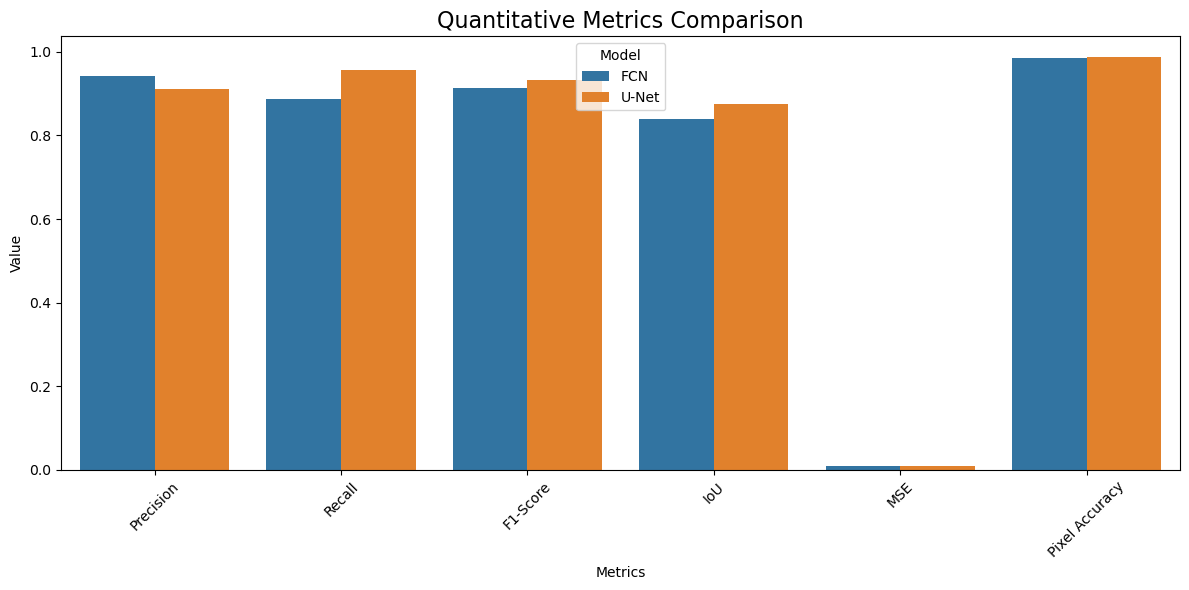

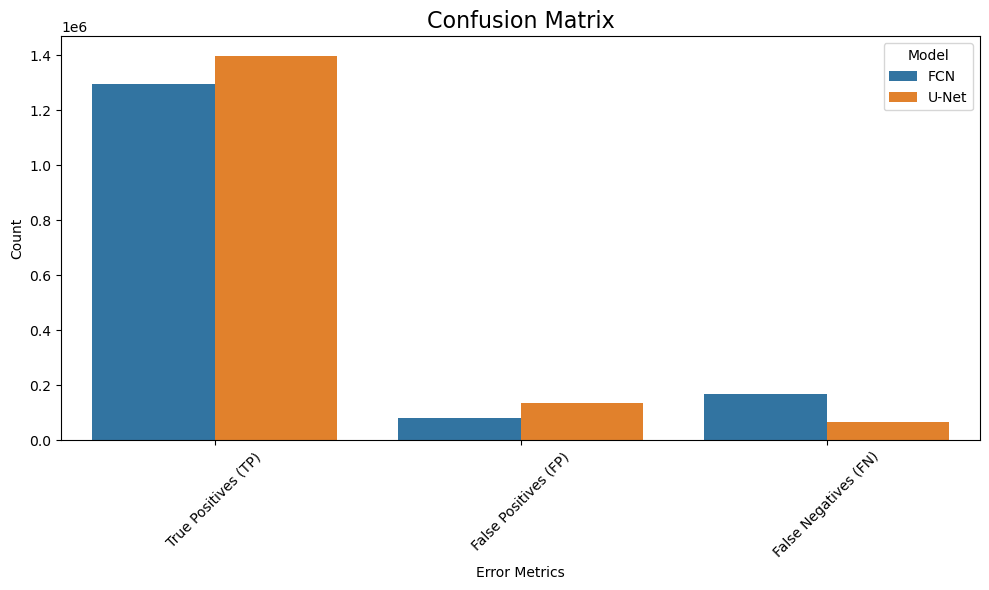

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Quantitative Metrics Bar Plot
def plot_metrics(df, metrics, title):
    df_melted = df.melt(id_vars="Model", value_vars=metrics, var_name="Metric", value_name="Value")
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_melted, x="Metric", y="Value", hue="Model")
    plt.title(title, fontsize=16)
    plt.ylabel("Value")
    plt.xlabel("Metrics")
    plt.xticks(rotation=45)
    plt.legend(title="Model")
    plt.tight_layout()
    plt.show()

quantitative_metrics = [
    "Precision", "Recall", "F1-Score", "IoU", "MSE", "Pixel Accuracy"
]

plot_metrics(metrics_df, quantitative_metrics, "Quantitative Metrics Comparison")

# Error Analysis Plot
def plot_error_analysis(df, metrics, title):
    df_error = df.melt(id_vars="Model", value_vars=metrics, var_name="Confusion Matrix", value_name="Value")
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_error, x="Confusion Matrix", y="Value", hue="Model")
    plt.title(title, fontsize=16)
    plt.ylabel("Count")
    plt.xlabel("Confusion Metrics")
    plt.xticks(rotation=45)
    plt.legend(title="Model")
    plt.tight_layout()
    plt.show()

error_metrics = [
    "True Positives (TP)", "False Positives (FP)", "False Negatives (FN)"
]

plot_error_analysis(metrics_df, error_metrics, "Confusion Matrix")

# Damage Classification Model Result and Performance